In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main

/content/gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# Training loop
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
from torch.nn.utils.rnn import pad_sequence


In [4]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
#data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/WADI/WADI_NORMALIZED_DATA.csv')
data_norm_anom = data_norm_anom.iloc[0:100000]
data_norm_anom = data_norm_anom.dropna()

df_normal = data_norm_anom[data_norm_anom['Label'] == 0]
df_normal = df_normal.iloc[:, 0:-1]
df_normal.shape

(93873, 26)

In [5]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
#data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/WADI/WADI_NORMALIZED_DATA.csv')
data_norm_anom = data_norm_anom.iloc[0:20000]
data_norm_anom = data_norm_anom.dropna()

df_anomaly = data_norm_anom[data_norm_anom['Label'] == 1]
df_anomaly = df_anomaly.iloc[:, 0:-1]
df_anomaly.shape

(4466, 26)

In [6]:
df_anomaly = df_anomaly.values
df_anomaly.shape

(4466, 26)

In [7]:
df_normal = df_normal.values
df_normal.shape

(93873, 26)

In [8]:
import numpy as np
import random

class SyntheticAnomalyGenerator:
    def __init__(self,
                 window_size,
                 reference_anomalies,
                 anomaly_types=['local_perturbation']):
        """
        Initializes the anomaly generator that oversamples real anomaly data
        but applies small perturbations to create a local neighborhood around
        the real anomalies.

        Args:
            window_size (int): The size of the anomaly window to inject.
            reference_anomalies (np.ndarray): Real anomaly data from which to oversample.
              Shape could be (num_anomalies, sequence_length, num_features) or
              (num_anomalies, num_features) if each row is a snippet, etc.
            anomaly_types (list): We keep it flexible, but default to ['local_perturbation'].
        """
        self.anomaly_types = anomaly_types
        self.window_size = window_size

        # Real anomaly data to oversample from
        self.reference_anomalies = reference_anomalies

    def inject_anomaly_into_sequence(self, sequence):
        """
        Called externally to inject an anomaly into 'sequence' by
        picking a real anomaly snippet, perturbing it, and overlaying.
        """
        anomalous_sequence = sequence.copy()
        anomaly_type = random.choice(self.anomaly_types)

        seq_length, num_features = anomalous_sequence.shape

        if seq_length <= self.window_size:
            t0 = 0
            t1 = seq_length
        else:
            t0 = random.randint(0, seq_length - self.window_size)
            t1 = t0 + self.window_size

        if anomaly_type == 'local_perturbation':
            anomalous_sequence = self.local_perturbation_injection(anomalous_sequence, t0, t1)
        elif anomaly_type == 'permutation_anomaly':
            # optional, if you want partial permutations
            anomalous_sequence = self.permutation_anomaly(anomalous_sequence, t0, t1)

        return anomalous_sequence

    def local_perturbation_injection(self, sequence, t0, t1):
        """
        1) Randomly pick a real anomaly snippet from reference_anomalies.
        2) Possibly adapt or clamp it to 'window_size'.
        3) Add small random perturbations (noise, slight scaling, partial permutations, etc.).
        4) Overlay onto 'sequence[t0:t1]'.
        """
        anomalous_sequence = sequence.copy()
        window_length = t1 - t0
        seq_length, num_features = anomalous_sequence.shape

        # 1) pick a random anomaly snippet from reference_anomalies
        #    Suppose reference_anomalies has shape (num_anomalies, anomaly_length, num_features)
        #    or (num_anomalies, num_features) if each row is a snippet.
        rand_idx = random.randint(0, self.reference_anomalies.shape[0]-1)
        real_anomaly_snippet = self.reference_anomalies[rand_idx]

        # Check if real_anomaly_snippet is 2D or 1D
        if real_anomaly_snippet.ndim == 1:
            # shape (num_features,) => we replicate or clamp it
            # e.g. we'll just tile it for 'window_length'
            real_anomaly_snippet = np.tile(real_anomaly_snippet, (window_length,1))
        elif real_anomaly_snippet.shape[0] != window_length:
            # We do a clamp or pad approach:
            real_len = real_anomaly_snippet.shape[0]
            if real_len > window_length:
                # clamp
                start_ = random.randint(0, real_len - window_length)
                real_anomaly_snippet = real_anomaly_snippet[start_:start_+window_length, :]
            else:
                # if real_len < window_length => pad repeats or edge
                repeats_needed = window_length - real_len
                # simplest => tile or pad
                real_anomaly_snippet = np.concatenate([
                    real_anomaly_snippet,
                    np.tile(real_anomaly_snippet[-1,:], (repeats_needed,1))
                ], axis=0)

        # Now real_anomaly_snippet is shape (window_length, num_features)

        # 2) Add small perturbations
        perturbed_snippet = self.apply_small_perturbations(real_anomaly_snippet)

        # 3) Overlay
        anomalous_sequence[t0:t1] = perturbed_snippet
        return anomalous_sequence

    def apply_small_perturbations(self, snippet):
        """
        snippet shape: (window_length, num_features)
        We'll do e.g.:
          - small gaussian noise
          - slight random scaling per feature
          - partial permutations of a few rows (rare)
        all to keep changes mild.
        """
        w_len, n_feats = snippet.shape
        snippet_ = snippet.copy()

        # A) small gaussian noise
        noise_std = 0.05 * np.std(snippet_)  # e.g. 5% of snippet's std
        noise = np.random.normal(0, noise_std, snippet_.shape)
        snippet_ += noise

        # B) slight random scaling per feature
        # e.g. each feature f => scale_f in [0.95,1.05]
        scales = 0.95 + 0.1*np.random.rand(n_feats)
        for f in range(n_feats):
            snippet_[:, f] *= scales[f]

        # C) partial row permutation, only a few rows
        # e.g. we permute 10% of the snippet rows:
        row_count = int(0.1 * w_len)  # 10% of rows
        if row_count>1:
            perm_indices = np.random.choice(w_len, size=row_count, replace=False)
            # shuffle those rows
            snippet_[perm_indices] = snippet_[np.random.permutation(perm_indices)]

        return snippet_

    def permutation_anomaly(self, sequence, t0, t1):
        """
        If you want a direct 'permutation_anomaly' approach:
        """
        anomalous_sequence = sequence.copy()
        window = anomalous_sequence[t0:t1]
        perm_indices = np.random.permutation(len(window))
        permuted_window = window[perm_indices]
        anomalous_sequence[t0:t1] = permuted_window
        return anomalous_sequence


In [9]:
def extract_sequences(time_series_data, window_size, step_size):
    total_length, num_features = time_series_data.shape
    sequences = []

    for start_idx in range(0, total_length - window_size + 1, step_size):
        end_idx = start_idx + window_size
        sequence = time_series_data[start_idx:end_idx]
        sequences.append(sequence)

    return sequences

In [10]:
def generate_consecutive_pairs(sequences, sequence_labels):
    """
    Generate pairs of consecutive sequences.

    Args:
        sequences (list): List of sequences.
        sequence_labels (list): Corresponding labels for each sequence.

    Returns:
        x1_pairs (list): List of sequences for x1.
        x2_pairs (list): List of sequences for x2.
        pair_labels (list): List of labels for each pair (0 for normal-normal, 1 for anomaly-involved).
    """
    x1_pairs = []
    x2_pairs = []
    pair_labels = []

    for i in range(len(sequences) - 1):
        x1 = sequences[i]
        x2 = sequences[i + 1]
        label = 0  # Default to normal-normal

        # If either sequence is anomalous, label the pair as anomaly-involved
        if sequence_labels[i] == 1 or sequence_labels[i + 1] == 1:
            label = 1

        x1_pairs.append(x1)
        x2_pairs.append(x2)
        pair_labels.append(label)

    return x1_pairs, x2_pairs, pair_labels


In [11]:
def collate_fn(batch):
    x1_batch, x2_batch, labels = zip(*batch)

    x1_batch = [torch.tensor(x, dtype=torch.float32) for x in x1_batch]
    x2_batch = [torch.tensor(x, dtype=torch.float32) for x in x2_batch]

    x1_lengths = torch.tensor([seq.size(0) for seq in x1_batch], dtype=torch.long)
    x2_lengths = torch.tensor([seq.size(0) for seq in x2_batch], dtype=torch.long)

    padded_x1 = pad_sequence(x1_batch, batch_first=True, padding_value=0.0)
    padded_x2 = pad_sequence(x2_batch, batch_first=True, padding_value=0.0)

    labels = torch.tensor(labels, dtype=torch.float32)  # For contrastive loss, labels should be float

    max_len_x1 = padded_x1.size(1)
    max_len_x2 = padded_x2.size(1)

    range_x1 = torch.arange(max_len_x1).unsqueeze(0).expand(len(x1_lengths), max_len_x1)
    range_x2 = torch.arange(max_len_x2).unsqueeze(0).expand(len(x2_lengths), max_len_x2)

    x1_mask = (range_x1 >= x1_lengths.unsqueeze(1)).to(torch.bool)
    x2_mask = (range_x2 >= x2_lengths.unsqueeze(1)).to(torch.bool)

    return padded_x1, padded_x2, labels, x1_mask, x2_mask


In [12]:
def apply_synthetic_anomalies_to_sequences(sequences, anomaly_percentage, anomaly_generator):
    """
    Inject synthetic anomalies into a specified percentage of sequences.

    Args:
        sequences (list): List of sequences extracted from the time series data.
        anomaly_percentage (float): Percentage of sequences to inject anomalies (0.1 to 1.0).
        anomaly_generator (SyntheticAnomalyGenerator): An instance of the anomaly generator.

    Returns:
        augmented_sequences (list): List of sequences after injecting anomalies.
        sequence_labels (list): Labels for each sequence (0 for normal, 1 for anomaly).
    """
    num_sequences = len(sequences)
    num_anomalous_sequences = int(num_sequences * anomaly_percentage)
    anomaly_indices = set(random.sample(range(num_sequences), num_anomalous_sequences))

    augmented_sequences = []
    sequence_labels = []

    for i, seq in enumerate(sequences):
        if i in anomaly_indices:
            # Inject anomaly into the entire sequence
            augmented_seq = anomaly_generator.inject_anomaly_into_sequence(seq)
            augmented_sequences.append(augmented_seq)
            sequence_labels.append(1)
        else:
            # Normal sequence
            augmented_sequences.append(seq)
            sequence_labels.append(0)

    return augmented_sequences, sequence_labels


In [13]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x1_pairs, x2_pairs, pair_labels, transform=None):
        assert len(x1_pairs) == len(x2_pairs) == len(pair_labels), "All inputs must have the same length."
        self.x1_pairs = x1_pairs
        self.x2_pairs = x2_pairs
        self.pair_labels = pair_labels
        self.transform = transform

    def __len__(self):
        return len(self.pair_labels)

    def __getitem__(self, idx):
        x1 = self.x1_pairs[idx]
        x2 = self.x2_pairs[idx]
        label = self.pair_labels[idx]

        if self.transform:
            x1 = self.transform(x1)
            x2 = self.transform(x2)

        return x1, x2, label


In [14]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.output_proj = nn.Linear(model_dim, model_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x = self.input_proj(x)  # (batch_size, seq_length, model_dim)
        x = self.dropout(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, seq_length, model_dim)

        if src_key_padding_mask is not None:
            # Create data mask: True where data is present
            data_mask = (~src_key_padding_mask).unsqueeze(2).type_as(x)  # (batch_size, seq_length, 1)
            x = x * data_mask  # Zero out padding positions: (batch_size, seq_length, model_dim)
            x_sum = x.sum(dim=1)  # Sum over seq_length: (batch_size, model_dim)

            lengths = data_mask.sum(dim=1)  # Sum over seq_length: (batch_size, 1)
            lengths = lengths.clamp(min=1)  # Avoid division by zero
            x = x_sum / lengths  # (batch_size, model_dim)
        else:
            x = x.mean(dim=1)  # Average over seq_length: (batch_size, model_dim)

        x = self.output_proj(x)  # (batch_size, model_dim)
        x = self.activation(x)
        return x


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Normal(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Normal, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Anomaly(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Anomaly, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [17]:
import torch.nn.functional as F

def contrastive_loss(ll_gaussian, ll_vine, pair_labels, alpha=0.5, base_margin= 0.0):
    """
      A contrastive loss for separating normal vs. anomaly log-likelihoods with a *dynamic* margin:

      1) Normal frames => maximize log-likelihood => loss = -LL_normal
      2) Anomaly frames => LL_anomaly <= (mean_normal_LL - base_offset) on a per-sample basis.

    Now we receive both Gaussian and Studen-t LL. We pick the appropriate LL based on the labels:
    - Normal pairs (label=0) -> Gaussian Copula LL
    - Anomaly pairs (label=1) -> Vine Copula LL
    """
    pair_labels = pair_labels.view(-1)
    # Select appropriate LL based on labels
    chosen_ll = torch.where(pair_labels == 0, ll_gaussian, ll_vine)

    normal_ll = chosen_ll[pair_labels == 0]
    anomaly_ll = chosen_ll[pair_labels == 1]
    #print (f"Normal LL: {normal_ll.mean()}")
    #print (f"Anomaly LL: {anomaly_ll.mean()}")

    if len(normal_ll) > 0:
        loss_normal = -normal_ll
        mean_normal_ll = normal_ll.mean()
    else:
        loss_normal = torch.tensor(0.0, device=chosen_ll.device)
        mean_normal_ll = torch.tensor(0.0, device=chosen_ll.device)

    # -----------------------
    # Anomaly portion
    # -----------------------
    # We'll define a *dynamic margin* for anomalies
    # margin_dyn = mean_normal_ll - base_offset
    # Then for each anomaly sample 'a', we want a <= margin_dyn => diff = a - margin_dyn => F.relu(diff)
    # If diff>0 => penalty
    if len(anomaly_ll) > 0:
        margin_dyn = mean_normal_ll - base_margin
        # shape (#anomalies,)
        diff = anomaly_ll - margin_dyn
        # sample-level margin
        loss_anomaly = alpha * F.relu(diff).mean()
    else:
        loss_anomaly = torch.tensor(0.0, device=device)

    total_loss = (1 - alpha) * loss_normal.mean() + loss_anomaly.mean()


      # Monitoring: Print average log-likelihoods for debugging
    if len(normal_ll) > 0:
        print(f"Contrastive Loss - Normal LL Mean: {loss_normal.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Normal Samples in Batch.")

    if len(anomaly_ll) > 0:
        print(f"Contrastive Loss - Anomalous LL Mean: {loss_anomaly.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Anomalous Samples in Batch.")

    return total_loss

In [18]:
class AnomalyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout, embedding_dim=64):
        super(AnomalyTransformer, self).__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout)

        # We now have two different copulas
        self.gaussian_copula = StudentTCopula_Normal(latent_dim=2 * model_dim)
        self.vine_copula = StudentTCopula_Anomaly(latent_dim=2 * model_dim)

        self.embedding_layer = nn.Linear(2 * model_dim, embedding_dim)

    def forward(self, x1, x2, mask1=None, mask2=None):
        z1 = self.encoder(x1, src_key_padding_mask=mask1)
        z2 = self.encoder(x2, src_key_padding_mask=mask2)
        z = torch.cat((z1, z2), dim=1)

        # Compute both Gaussian and Vine likelihoods
        ll_gaussian = self.gaussian_copula(z)
        ll_vine = self.vine_copula(z)
        return ll_gaussian, ll_vine

    def get_embeddings(self, x1, x2, mask1=None, mask2=None):
        # Instead of passing x1, x2 as (B, features),
        # we do x1 => (B, 1, features)
        if x1.dim() == 2:
            x1 = x1.unsqueeze(1)  # shape => (B,1,features)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(1)

        transformed_x1 = self.encoder(x1, src_key_padding_mask=mask1)
        transformed_x2 = self.encoder(x2, src_key_padding_mask=mask2)

        # Now each is likely shape (B, seq_len=1, model_dim) or (B, model_dim)
        # if the encoder does a mean over seq_len => shape (B, model_dim).
        # We need to confirm the final shape. If the encoder returns 3D => e.g. (B,1,model_dim),
        # we might want to reduce it to 2D => (B,model_dim) by mean over dim=1.
        if transformed_x1.dim() == 3:
            # e.g. if shape => (B,1,hidden_dim), reduce to (B, hidden_dim)
            transformed_x1 = transformed_x1.mean(dim=1)
        if transformed_x2.dim() == 3:
            transformed_x2 = transformed_x2.mean(dim=1)

        # Now each => (B, hidden_dim)
        combined = torch.cat((transformed_x1, transformed_x2), dim=1)  # => (B,2*hidden_dim)
        embeddings = self.embedding_layer(combined)  # => (B, embed_dim)
        return embeddings

In [ ]:
#

In [19]:
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# class TransformerEncoder(nn.Module):
#     def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
#         super(TransformerEncoder, self).__init__()
#         # project input to model_dim
#         self.input_proj = nn.Linear(input_dim, model_dim)
#         # LSTM in place of Transformer
#         self.lstm = nn.LSTM(
#             input_size=model_dim,
#             hidden_size=model_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout
#         )
#         # same output proj & activation as before
#         self.output_proj = nn.Linear(model_dim, model_dim)
#         self.activation  = nn.ReLU()
#         self.dropout     = nn.Dropout(dropout)

#     def forward(self, x, src_key_padding_mask=None):
#         """
#         x:             (batch, seq_len, input_dim)
#         src_key_padding_mask: (batch, seq_len) with True at PAD positions
#         """
#         # 1) project & dropout
#         x = self.input_proj(x)        # → (batch, seq_len, model_dim)
#         x = self.dropout(x)

#         # 2) optionally pack to ignore padding
#         if src_key_padding_mask is not None:
#             # compute lengths from mask
#             lengths = (~src_key_padding_mask).sum(1).cpu()
#             packed = pack_padded_sequence(
#                 x, lengths, batch_first=True, enforce_sorted=False
#             )
#             packed_out, (h_n, _) = self.lstm(packed)
#             # unpack if you ever need the full outputs, but we just use h_n
#         else:
#             _, (h_n, _) = self.lstm(x)

#         # 3) take the last layer's hidden state as summary
#         h = h_n[-1]  # (batch, model_dim)

#         # 4) project + activate
#         out = self.output_proj(h)
#         out = self.activation(out)
#         return out


In [19]:
window_size = 100
step_size = 50  # Non-overlapping sequences
anomaly_percentage = 0.7 # 20% of sequences will be anomalous
batch_size = 64


# Step 1: Extract sequences from the raw data
sequences = extract_sequences(df_normal, window_size=window_size, step_size=step_size)
print(f"Total extracted sequences: {len(sequences)}")


anomaly_generator = SyntheticAnomalyGenerator(
    window_size=50,
    reference_anomalies=df_anomaly,
    anomaly_types=['local_perturbation']  # can add 'permutation_anomaly' if desired
)

# Step 2: Inject anomalies into sequences
augmented_sequences, sequence_labels = apply_synthetic_anomalies_to_sequences(
    sequences,
    anomaly_percentage=anomaly_percentage,
    anomaly_generator=anomaly_generator
)
print(f"Total anomalous sequences: {sum(sequence_labels)}")

# Step 3: Generate consecutive pairs
x1_pairs, x2_pairs, pair_labels = generate_consecutive_pairs(augmented_sequences, sequence_labels)
print(f"Total generated pairs: {len(pair_labels)}")
print(f"Anomaly-involved pairs: {sum(pair_labels)}")
print(f"Normal-normal pairs: {len(pair_labels) - sum(pair_labels)}")


Total extracted sequences: 1876
Total anomalous sequences: 1313
Total generated pairs: 1875
Anomaly-involved pairs: 1675
Normal-normal pairs: 200


In [20]:
from torch.utils.data import DataLoader, Subset
import torch

# 1) Train dataset from x1_pairs, x2_pairs, pair_labels
train_dataset = TimeSeriesDataset(
    x1_pairs=x1_pairs,
    x2_pairs=x2_pairs,
    pair_labels=pair_labels,
    transform=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
# 2) Build a new dataset for the separate test data
import pandas as pd
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.dropna()

data_test = data_norm_anom.iloc[100000:200000]
test_features = data_test.iloc[:, :-1].values
test_labels   = data_test.iloc[:,  -1].values
print (test_features.shape, test_labels.shape)

(100000, 26) (100000,)


In [22]:
# Define a simple dataset
class SimpleTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels   = labels
        self.transform= transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

test_dataset_all = SimpleTimeSeriesDataset(test_features, test_labels)

In [23]:
import numpy as np
from torch.utils.data import Subset

# assume test_labels is your full chronological array of 0/1 labels
N = len(test_labels)
val_size = N // 2

# 1) find the indices of each class
normal_idx = np.where(test_labels == 0)[0]   # e.g. array of all normal positions
anom_idx   = np.where(test_labels == 1)[0]   # array of all anomaly positions

# 2) decide how many of each go into the val fold,
#    but don’t request more anomalies than you actually have
nom_needed = val_size - min(len(anom_idx), int(val_size * len(anom_idx) / N))
anom_needed = min(len(anom_idx), val_size - nom_needed)

# 3) slice off that many from the start of each index list
val_norm_inds = normal_idx[:nom_needed]
val_anom_inds = anom_idx[:anom_needed]

# 4) combine and sort so that chronology within val is preserved
val_inds = np.sort(np.concatenate([val_norm_inds, val_anom_inds]))

# 5) the remaining indices become your test set
test_norm_inds = normal_idx[nom_needed:]
test_anom_inds = anom_idx[anom_needed:]
test_inds = np.sort(np.concatenate([test_norm_inds, test_anom_inds]))

# 6) build your subsets exactly as before
val_subset  = Subset(test_dataset_all, val_inds.tolist())
test_subset = Subset(test_dataset_all, test_inds.tolist())

val_loader = DataLoader(val_subset,  batch_size=64, shuffle=False, num_workers=4)
test_loader= DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)

# no more SyntheticAnomalyGenerator here, either
# test_ds = WindowedDataset(
#     features   = Xtest,
#     labels     = ytest,
#     window_size= L,
#     stride     = 1,
#     min_anoms  = k   # if you want “at least k points in a window”
# )
#test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


# 7) now you can index into test_labels safely:
val_true_ts = test_labels[val_inds]  # contains both 0’s and 1’s


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = df_normal.shape[1]  # Number of features in the input data
model_dim = 32#128 #64
num_heads = 4
num_layers = 2
dropout = 0.3

model = AnomalyTransformer(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


**PLOTTING AND STATS**


In [25]:
import numpy as np

def compute_add(true_ts_labels, window_size, window_preds, stride=1):
    """
    true_ts_labels: 1D array of 0/1 at every timestamp (length T)
    window_size:    number of timestamps per window (L)
    window_preds:   1D array of 0/1 window‐level predictions (length N)
    stride:         step between windows (default 1)
    """
    # 1. find all ground‐truth anomaly events
    events = []
    in_event = False
    for t, y in enumerate(true_ts_labels):
        if y and not in_event:
            start = t
            in_event = True
        if in_event and not y:
            events.append((start, t-1))
            in_event = False
    if in_event:
        events.append((start, len(true_ts_labels)-1))

    # 2. map each window index → its end‐time in the original timeline
    window_ends = [i*stride + window_size - 1 for i in range(len(window_preds))]

    # 3. for each event, find first flagged window and compute delay
    delays = []
    for (start, _) in events:
        # windows whose end ≥ event start and prediction == 1
        candidates = [we for we, p in zip(window_ends, window_preds) if p and we >= start]
        if candidates:
            delays.append(min(candidates) - start)
        # else: you never detected that event (you can drop or assign a large penalty)
    return np.mean(delays) if delays else np.nan


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch

# Function to calculate F1_PA
def calculate_f1_pa(labels, preds):
    true_segments = []
    pred_segments = []

    # Get segments for true labels
    i = 0
    while i < len(labels):
        if labels[i] == 1:
            start = i
            while i < len(labels) and labels[i] == 1:
                i += 1
            true_segments.append((start, i - 1))
        i += 1

    # Get segments for predictions
    i = 0
    while i < len(preds):
        if preds[i] == 1:
            start = i
            while i < len(preds) and preds[i] == 1:
                i += 1
            pred_segments.append((start, i - 1))
        i += 1

    # Compute overlap
    tp = 0
    for t_start, t_end in true_segments:
        for p_start, p_end in pred_segments:
            if not (p_end < t_start or p_start > t_end):
                tp += 1
                break

    precision_pa = tp / len(pred_segments) if len(pred_segments) > 0 else 0
    recall_pa = tp / len(true_segments) if len(true_segments) > 0 else 0
    f1_pa = 2 * precision_pa * recall_pa / (precision_pa + recall_pa) if precision_pa + recall_pa > 0 else 0

    return f1_pa

In [27]:
def validate(model, val_loader, device, threshold=None,
             window_size=None, true_ts_labels=None, stride=1):
    model.eval()
    all_ll, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 5:
                x1, x2, labels, m1, m2 = batch
                x1, x2 = x1.to(device), x2.to(device)
                labels  = labels.to(device)
                m1, m2  = m1.to(device), m2.to(device)
                ll_g, ll_v = model(x1, x2, mask1=m1, mask2=m2)

            elif len(batch) == 3:
                x1, x2, labels = batch
                x1, x2 = x1.to(device), x2.to(device)
                labels = labels.to(device)
                ll_g, ll_v = model(x1, x2)

            elif len(batch) == 2:
                feats, labels = batch
                feats  = feats.to(device, dtype=torch.float32)
                labels = labels.to(device)
                # Only unsqueeze if feats is 2D (batch, dim)
                if feats.dim() == 2:
                    feats = feats.unsqueeze(1)
                # else feats.dim()==3: (batch, seq_len, dim) → OK
                ll_g, ll_v = model(feats, feats)

            else:
                raise ValueError(f"Unexpected batch size: {len(batch)}")

            ll_f = torch.where(labels==0, ll_g, ll_v)
            all_ll.extend(ll_f.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_ll      = np.array(all_ll)
    all_labels  = np.array(all_labels)

    # pick threshold by best F1
    if threshold is None:
        best_f1, best_thr = 0.0, 0.0
        for thr in np.linspace(all_ll.min(), all_ll.max(), 100):
            preds = (all_ll < thr).astype(int)
            f1 = f1_score(all_labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_thr = f1, thr
        threshold = best_thr

    preds = (all_ll < threshold).astype(int)

    # compute metrics
    accuracy  = precision_score(all_labels, preds, zero_division=0)  # typo in your code? Should be accuracy_score
    accuracy  = (all_labels == preds).mean()
    precision = precision_score(all_labels, preds, zero_division=0)
    recall    = recall_score(all_labels, preds, zero_division=0)
    auc_roc   = roc_auc_score(all_labels, -all_ll)
    f1_pa     = f1_score(all_labels, preds, zero_division=0)  # or your custom PA

    stats = {
        'accuracy':  accuracy,
        'precision': precision,
        'recall':    recall,
        'auc_roc':   auc_roc,
        'f1_pa':     f1_pa,
        'threshold': threshold
    }

    if window_size is not None and true_ts_labels is not None:
        stats['add'] = compute_add(true_ts_labels, window_size, preds, stride)

    return stats

In [28]:
def plot_log_likelihoods(model, loader, device, dataset_name="Dataset"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torch import no_grad

    model.eval()
    log_likelihoods = []
    labels = []

    normal_log_likelihoods = []
    anomaly_log_likelihoods = []

    with no_grad():
        for batch in loader:
            if len(batch) == 5:
                # old approach: (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device)
                padded_x2 = padded_x2.to(device)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # model returns (ll_gaussian, ll_vine)
                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 2:
                # new approach: (features, labels)
                features, batch_labels = batch
                # shape => (batch_size, features) or (batch_size, seq_len, features)
                features = features.to(device, dtype=torch.float32)
                features = features.unsqueeze(1)  # => shape (B,1,features_dim)

                batch_labels = batch_labels.to(device)

                # If your model expects two inputs, we pass the same feature twice
                ll_gaussian, ll_vine = model(features, features)
            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have ll_gaussian, ll_vine, and batch_labels
            # Normal => label=0 => use ll_gaussian
            # Anomaly=> label=1 => use ll_vine
            selected_ll = torch.where(batch_labels == 0, ll_gaussian, ll_vine)

            # Convert to CPU/NumPy
            selected_ll_np = selected_ll.cpu().numpy()
            labels_np = batch_labels.cpu().numpy()

            # Separate normal vs. anomaly for debugging
            normal_mask = (labels_np == 0)
            anomaly_mask= (labels_np == 1)

            normal_ll  = selected_ll_np[normal_mask]
            anomaly_ll = selected_ll_np[anomaly_mask]

            if len(normal_ll) > 0:
                normal_log_likelihoods.extend(normal_ll)
            if len(anomaly_ll) > 0:
                anomaly_log_likelihoods.extend(anomaly_ll)

            log_likelihoods.extend(selected_ll_np)
            labels.extend(labels_np)

    log_likelihoods = np.array(log_likelihoods)
    labels = np.array(labels)

    # Build a DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame({
        'Log-Likelihood': log_likelihoods,
        'Label': ['Anomaly' if lb == 1 else 'Normal' for lb in labels]
    })

    # Summary stats
    if len(normal_log_likelihoods) > 0:
        mean_normal = np.mean(normal_log_likelihoods)
    else:
        mean_normal = float('nan')

    if len(anomaly_log_likelihoods) > 0:
        mean_anomaly = np.mean(anomaly_log_likelihoods)
    else:
        mean_anomaly = float('nan')

    print(f"[{dataset_name}] Mean Normal Log-Likelihood: {mean_normal:.4f}")
    print(f"[{dataset_name}] Mean Anomaly Log-Likelihood: {mean_anomaly:.4f}")

    # Plot distributions via Seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='Log-Likelihood', hue='Label', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Log-Likelihood Distribution for {dataset_name} Set')
    plt.show()


In [29]:
import numpy as np
import torch
from torch.utils.data import Dataset

class WindowedDataset(Dataset):
    def __init__(self, features, labels, window_size, stride, min_anoms=1, transform=None):
        """
        features:    np.array of shape (T, d)
        labels:      np.array of shape (T,) with 0/1
        window_size: int, length of each frame
        stride:      int, step between frames
        min_anoms:   int, minimum number of 1’s in a window to call it anomalous
        """
        self.transform = transform
        Xw, yw = [], []
        T, d = features.shape

        for start in range(0, T - window_size + 1, stride):
            end = start + window_size
            x_win = features[start:end]      # shape (window_size, d)
            y_win = labels[start:end]        # shape (window_size,)

            # count anomalies in the window
            num_anoms = int(np.sum(y_win))

            # label = 1 only if at least k anomalies present
            label = 1 if num_anoms >= min_anoms else 0

            Xw.append(x_win)
            yw.append(label)

        self.X = np.stack(Xw, axis=0)        # shape (N_windows, window_size, d)
        self.y = np.array(yw, dtype=int)     # shape (N_windows,)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]                      # (window_size, d)
        y = self.y[idx]                      # 0 or 1
        if self.transform is not None:
            x = self.transform(x)
        return x, y


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

**LSTM + Copula**

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 82.3843
Contrastive Loss - Anomalous LL Mean: 149.2610
Contrastive Loss - Normal LL Mean: 106.1896
Contrastive Loss - Anomalous LL Mean: 156.7532
Contrastive Loss - Normal LL Mean: 88.9100
Contrastive Loss - Anomalous LL Mean: 151.5418
Contrastive Loss - Normal LL Mean: 96.4959
Contrastive Loss - Anomalous LL Mean: 152.5578
Contrastive Loss - Normal LL Mean: 90.0134
Contrastive Loss - Anomalous LL Mean: 150.9920
Contrastive Loss - Normal LL Mean: 84.8859
Contrastive Loss - Anomalous LL Mean: 149.0544
Contrastive Loss - Normal LL Mean: 103.2781
Contrastive Loss - Anomalous LL Mean: 155.3728
Contrastive Loss - Normal LL Mean: 95.2251
Contrastive Loss - Anomalous LL Mean: 152.3139
Contrastive Loss - Normal LL Mean: 96.8799
Contrastive Loss - Anomalous LL Mean: 153.4936
Contrastive Loss - Normal LL Mean: 103.1286
Contrastive Loss - Anomalous LL Mean: 154.6655
Contrastive Loss - Normal LL Mean: 89.3574
Contrastive Loss - Anomalous LL Mean: 150.5701
Contras

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 88.1509
Contrastive Loss - Anomalous LL Mean: 149.7723
Contrastive Loss - Normal LL Mean: 98.4297
Contrastive Loss - Anomalous LL Mean: 152.2284
Contrastive Loss - Normal LL Mean: 81.8338
Contrastive Loss - Anomalous LL Mean: 147.7263
Contrastive Loss - Normal LL Mean: 93.8784
Contrastive Loss - Anomalous LL Mean: 150.8180
Contrastive Loss - Normal LL Mean: 89.7633
Contrastive Loss - Anomalous LL Mean: 149.3503
Contrastive Loss - Normal LL Mean: 87.7246
Contrastive Loss - Anomalous LL Mean: 149.2934
Contrastive Loss - Normal LL Mean: 111.9384
Contrastive Loss - Anomalous LL Mean: 158.1438
Contrastive Loss - Normal LL Mean: 75.6724
Contrastive Loss - Anomalous LL Mean: 145.2108
Contrastive Loss - Normal LL Mean: 111.5499
Contrastive Loss - Anomalous LL Mean: 157.2234
Contrastive Loss - Normal LL Mean: 88.6829
Contrastive Loss - Anomalous LL Mean: 150.0161
Contrastive Loss - Normal LL Mean: 85.0266
Contrastive Loss - Anomalous LL Mean: 148.2479
Contrast

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 89.0288
Contrastive Loss - Anomalous LL Mean: 148.1911
Contrastive Loss - Normal LL Mean: 85.4324
Contrastive Loss - Anomalous LL Mean: 148.0254
Contrastive Loss - Normal LL Mean: 88.8242
Contrastive Loss - Anomalous LL Mean: 147.6461
Contrastive Loss - Normal LL Mean: 78.2482
Contrastive Loss - Anomalous LL Mean: 145.5912
Contrastive Loss - Normal LL Mean: 91.6809
Contrastive Loss - Anomalous LL Mean: 149.5153
Contrastive Loss - Normal LL Mean: 75.3302
Contrastive Loss - Anomalous LL Mean: 143.3880
Contrastive Loss - Normal LL Mean: 84.2159
Contrastive Loss - Anomalous LL Mean: 147.1689
Contrastive Loss - Normal LL Mean: 91.9003
Contrastive Loss - Anomalous LL Mean: 149.2555
Contrastive Loss - Normal LL Mean: 85.0240
Contrastive Loss - Anomalous LL Mean: 147.3494
Contrastive Loss - Normal LL Mean: 78.6048
Contrastive Loss - Anomalous LL Mean: 145.0681
Contrastive Loss - Normal LL Mean: 86.4083
Contrastive Loss - Anomalous LL Mean: 147.5725
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 93.0111
Contrastive Loss - Anomalous LL Mean: 148.7326
Contrastive Loss - Normal LL Mean: 112.5821
Contrastive Loss - Anomalous LL Mean: 154.8122
Contrastive Loss - Normal LL Mean: 70.8122
Contrastive Loss - Anomalous LL Mean: 139.8500
Contrastive Loss - Normal LL Mean: 86.1798
Contrastive Loss - Anomalous LL Mean: 145.1992
Contrastive Loss - Normal LL Mean: 70.0005
Contrastive Loss - Anomalous LL Mean: 140.0562
Contrastive Loss - Normal LL Mean: 85.2766
Contrastive Loss - Anomalous LL Mean: 144.7768
Contrastive Loss - Normal LL Mean: 99.1812
Contrastive Loss - Anomalous LL Mean: 149.2917
Contrastive Loss - Normal LL Mean: 84.5533
Contrastive Loss - Anomalous LL Mean: 144.7625
Contrastive Loss - Normal LL Mean: 102.1799
Contrastive Loss - Anomalous LL Mean: 150.7295
Contrastive Loss - Normal LL Mean: 80.3696
Contrastive Loss - Anomalous LL Mean: 142.4655
Contrastive Loss - Normal LL Mean: 100.4668
Contrastive Loss - Anomalous LL Mean: 150.2739
Contras

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 86.2114
Contrastive Loss - Anomalous LL Mean: 143.2357
Contrastive Loss - Normal LL Mean: 65.8453
Contrastive Loss - Anomalous LL Mean: 137.5733
Contrastive Loss - Normal LL Mean: 79.7019
Contrastive Loss - Anomalous LL Mean: 140.9712
Contrastive Loss - Normal LL Mean: 104.1081
Contrastive Loss - Anomalous LL Mean: 148.7386
Contrastive Loss - Normal LL Mean: 66.8849
Contrastive Loss - Anomalous LL Mean: 138.3605
Contrastive Loss - Normal LL Mean: 86.8781
Contrastive Loss - Anomalous LL Mean: 144.7178
Contrastive Loss - Normal LL Mean: 89.5319
Contrastive Loss - Anomalous LL Mean: 144.9941
Contrastive Loss - Normal LL Mean: 84.8570
Contrastive Loss - Anomalous LL Mean: 142.6009
Contrastive Loss - Normal LL Mean: 87.0862
Contrastive Loss - Anomalous LL Mean: 143.8464
Contrastive Loss - Normal LL Mean: 86.4809
Contrastive Loss - Anomalous LL Mean: 142.5735
Contrastive Loss - Normal LL Mean: 106.1413
Contrastive Loss - Anomalous LL Mean: 150.5774
Contrast

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 78.7824
Contrastive Loss - Anomalous LL Mean: 138.2070
Contrastive Loss - Normal LL Mean: 97.4784
Contrastive Loss - Anomalous LL Mean: 145.0340
Contrastive Loss - Normal LL Mean: 83.0444
Contrastive Loss - Anomalous LL Mean: 140.3739
Contrastive Loss - Normal LL Mean: 93.1081
Contrastive Loss - Anomalous LL Mean: 143.4337
Contrastive Loss - Normal LL Mean: 72.9023
Contrastive Loss - Anomalous LL Mean: 138.1698
Contrastive Loss - Normal LL Mean: 81.0823
Contrastive Loss - Anomalous LL Mean: 139.2581
Contrastive Loss - Normal LL Mean: 84.2607
Contrastive Loss - Anomalous LL Mean: 139.4848
Contrastive Loss - Normal LL Mean: 77.6173
Contrastive Loss - Anomalous LL Mean: 136.4684
Contrastive Loss - Normal LL Mean: 80.2137
Contrastive Loss - Anomalous LL Mean: 139.2733
Contrastive Loss - Normal LL Mean: 97.6437
Contrastive Loss - Anomalous LL Mean: 143.1788
Contrastive Loss - Normal LL Mean: 65.1997
Contrastive Loss - Anomalous LL Mean: 134.2390
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 72.4420
Contrastive Loss - Anomalous LL Mean: 133.4211
Contrastive Loss - Normal LL Mean: 95.8681
Contrastive Loss - Anomalous LL Mean: 140.8738
Contrastive Loss - Normal LL Mean: 112.0884
Contrastive Loss - Anomalous LL Mean: 147.3120
Contrastive Loss - Normal LL Mean: 74.6878
Contrastive Loss - Anomalous LL Mean: 133.8956
Contrastive Loss - Normal LL Mean: 76.6780
Contrastive Loss - Anomalous LL Mean: 134.5320
Contrastive Loss - Normal LL Mean: 90.1453
Contrastive Loss - Anomalous LL Mean: 139.4424
Contrastive Loss - Normal LL Mean: 89.7914
Contrastive Loss - Anomalous LL Mean: 139.6611
Contrastive Loss - Normal LL Mean: 84.7443
Contrastive Loss - Anomalous LL Mean: 135.1956
Contrastive Loss - Normal LL Mean: 83.3282
Contrastive Loss - Anomalous LL Mean: 135.6913
Contrastive Loss - Normal LL Mean: 78.3243
Contrastive Loss - Anomalous LL Mean: 135.3065
Contrastive Loss - Normal LL Mean: 86.3448
Contrastive Loss - Anomalous LL Mean: 137.5511
Contrasti

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 82.8846
Contrastive Loss - Anomalous LL Mean: 134.2973
Contrastive Loss - Normal LL Mean: 89.0724
Contrastive Loss - Anomalous LL Mean: 134.4746
Contrastive Loss - Normal LL Mean: 80.3093
Contrastive Loss - Anomalous LL Mean: 134.1140
Contrastive Loss - Normal LL Mean: 76.6215
Contrastive Loss - Anomalous LL Mean: 129.8348
Contrastive Loss - Normal LL Mean: 83.0223
Contrastive Loss - Anomalous LL Mean: 133.8664
Contrastive Loss - Normal LL Mean: 81.8253
Contrastive Loss - Anomalous LL Mean: 130.4445
Contrastive Loss - Normal LL Mean: 83.0934
Contrastive Loss - Anomalous LL Mean: 134.0288
Contrastive Loss - Normal LL Mean: 72.8545
Contrastive Loss - Anomalous LL Mean: 126.9392
Contrastive Loss - Normal LL Mean: 79.8904
Contrastive Loss - Anomalous LL Mean: 131.1832
Contrastive Loss - Normal LL Mean: 98.7578
Contrastive Loss - Anomalous LL Mean: 135.2557
Contrastive Loss - Normal LL Mean: 76.5785
Contrastive Loss - Anomalous LL Mean: 131.0576
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 54.4243
Contrastive Loss - Anomalous LL Mean: 120.3239
Contrastive Loss - Normal LL Mean: 84.8650
Contrastive Loss - Anomalous LL Mean: 129.4732
Contrastive Loss - Normal LL Mean: 90.8072
Contrastive Loss - Anomalous LL Mean: 130.8694
Contrastive Loss - Normal LL Mean: 75.9676
Contrastive Loss - Anomalous LL Mean: 126.5761
Contrastive Loss - Normal LL Mean: 80.8316
Contrastive Loss - Anomalous LL Mean: 126.2693
Contrastive Loss - Normal LL Mean: 70.2376
Contrastive Loss - Anomalous LL Mean: 123.1758
Contrastive Loss - Normal LL Mean: 74.9707
Contrastive Loss - Anomalous LL Mean: 122.4954
Contrastive Loss - Normal LL Mean: 76.6248
Contrastive Loss - Anomalous LL Mean: 123.4453
Contrastive Loss - Normal LL Mean: 73.9681
Contrastive Loss - Anomalous LL Mean: 120.5876
Contrastive Loss - Normal LL Mean: 75.7821
Contrastive Loss - Anomalous LL Mean: 124.6484
Contrastive Loss - Normal LL Mean: 86.8882
Contrastive Loss - Anomalous LL Mean: 129.9104
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 77.7122
Contrastive Loss - Anomalous LL Mean: 122.0683
Contrastive Loss - Normal LL Mean: 60.5980
Contrastive Loss - Anomalous LL Mean: 117.1404
Contrastive Loss - Normal LL Mean: 85.7392
Contrastive Loss - Anomalous LL Mean: 120.1696
Contrastive Loss - Normal LL Mean: 84.8359
Contrastive Loss - Anomalous LL Mean: 122.2992
Contrastive Loss - Normal LL Mean: 61.1693
Contrastive Loss - Anomalous LL Mean: 115.4917
Contrastive Loss - Normal LL Mean: 73.7285
Contrastive Loss - Anomalous LL Mean: 117.2801
Contrastive Loss - Normal LL Mean: 89.8665
Contrastive Loss - Anomalous LL Mean: 124.6826
Contrastive Loss - Normal LL Mean: 73.6256
Contrastive Loss - Anomalous LL Mean: 118.8020
Contrastive Loss - Normal LL Mean: 89.4779
Contrastive Loss - Anomalous LL Mean: 125.4958
Contrastive Loss - Normal LL Mean: 64.8792
Contrastive Loss - Anomalous LL Mean: 112.6519
Contrastive Loss - Normal LL Mean: 82.2956
Contrastive Loss - Anomalous LL Mean: 119.5472
Contrastiv

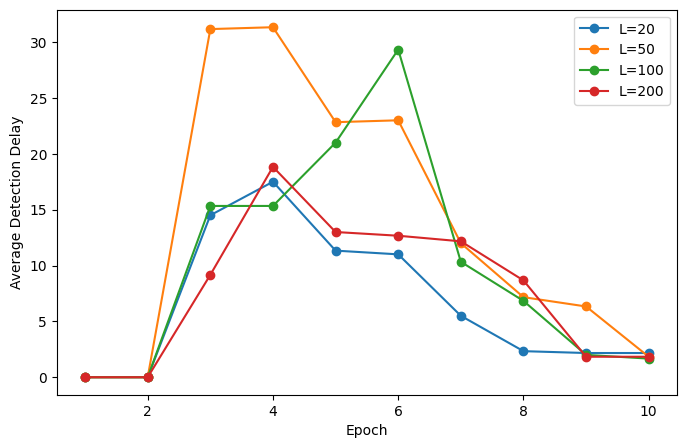

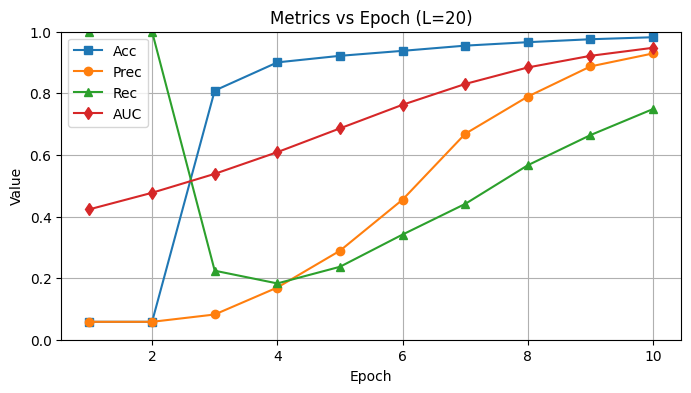

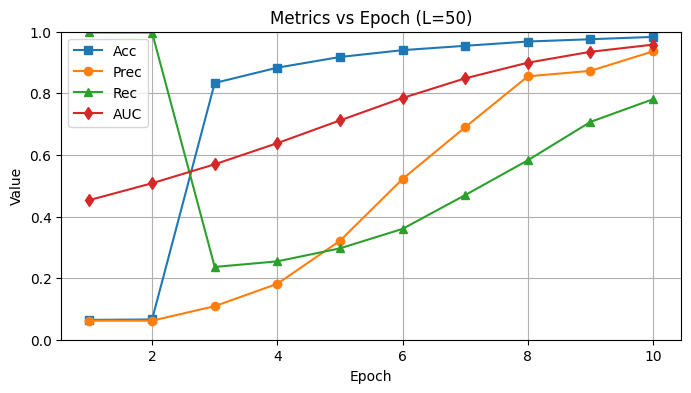

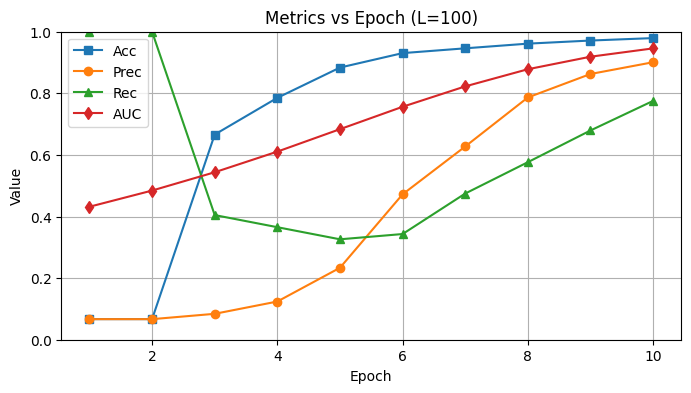

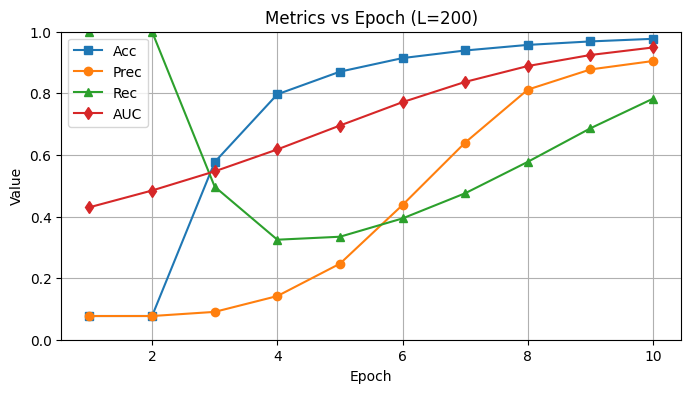

In [32]:
# ── D) HYPERPARAMS & DATA ──
num_epochs     =  10
window_lengths = [20, 50, 100, 200]
batch_size     = 64

val_indices = val_subset.indices
val_true_ts = np.array(test_labels[val_indices], dtype=int)


metrics_history = {
    L: {k: [] for k in
        ['accuracy','precision','recall','auc_roc','f1_pa','threshold','add']}
    for L in window_lengths
}

scheduler = ReduceLROnPlateau(optimizer, mode='max',
                              factor=0.5, patience=5, verbose=True)

# ── E) TRAIN/VALIDATE ──
for epoch in range(num_epochs):
    # TRAIN
    model.train()
    total_loss = 0.0
    for x1, x2, y, m1, m2 in train_loader:
        x1, x2, y, m1, m2 = [t.to(device) for t in (x1,x2,y,m1,m2)]
        optimizer.zero_grad()
        ll_g, ll_v = model(x1, x2, mask1=m1, mask2=m2)
        loss = contrastive_loss(ll_g, ll_v, y, alpha=0.3, base_margin=500.)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"\nEpoch {epoch+1}/{num_epochs} — Loss: {total_loss/len(train_loader):.4f}")

    # VALIDATE each L
    for L in window_lengths:
        # val_ds = WindowedDataset(test_features[val_indices],
        #                          test_labels[val_indices],
        #                          window_size=L, stride=1)

        k = 3
        val_ds = WindowedDataset(
            test_features[val_indices],
            test_labels[val_indices],
            window_size=L,
            stride=1,
            min_anoms=k
        )
        val_loader_L = DataLoader(val_ds,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=2)

        stats = validate(model, val_loader_L, device,
                         threshold=None,
                         window_size=L,
                         true_ts_labels=val_true_ts,
                         stride=1)
        for k in metrics_history[L]:
            metrics_history[L][k].append(stats[k])

        print(f" [L={L:3d}] Acc={stats['accuracy']:.3f}  "
              f"Prec={stats['precision']:.3f}  Rec={stats['recall']:.3f}  "
              f"AUC={stats['auc_roc']:.3f}  F1_PA={stats['f1_pa']:.3f}  "
              f"Thr={stats['threshold']:.3f}  ADD={stats['add']:.2f}")

    # scheduler.step(metrics_history[window_lengths[0]]['auc_roc'][-1])

# ── F) PLOTS ──

epochs = np.arange(1, num_epochs+1)
# ADD curves
plt.figure(figsize=(8,5))
for L in window_lengths:
    plt.plot(epochs, metrics_history[L]['add'], marker='o', label=f"L={L}")
plt.xlabel("Epoch"); plt.ylabel("Average Detection Delay"); plt.legend(); plt.show()

# Classification metrics per L
for L in window_lengths:
    plt.figure(figsize=(8,4))
    for m,label,mk in [
        ('accuracy', 'Acc','s'),
        ('precision','Prec','o'),
        ('recall','Rec','^'),
        ('auc_roc','AUC','d')
    ]:
        plt.plot(epochs, metrics_history[L][m],
                 marker=mk, label=label)
    plt.title(f"Metrics vs Epoch (L={L})")
    plt.xlabel("Epoch"); plt.ylabel("Value")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

**Transformer**

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 125.2251
Contrastive Loss - Anomalous LL Mean: 153.8019
Contrastive Loss - Normal LL Mean: 125.3131
Contrastive Loss - Anomalous LL Mean: 153.7797
Contrastive Loss - Normal LL Mean: 136.9798
Contrastive Loss - Anomalous LL Mean: 158.5287
Contrastive Loss - Normal LL Mean: 120.2298
Contrastive Loss - Anomalous LL Mean: 152.0781
Contrastive Loss - Normal LL Mean: 113.2348
Contrastive Loss - Anomalous LL Mean: 149.6186
Contrastive Loss - Normal LL Mean: 133.4863
Contrastive Loss - Anomalous LL Mean: 155.2612
Contrastive Loss - Normal LL Mean: 123.1067
Contrastive Loss - Anomalous LL Mean: 154.2376
Contrastive Loss - Normal LL Mean: 128.1478
Contrastive Loss - Anomalous LL Mean: 154.1207
Contrastive Loss - Normal LL Mean: 134.0013
Contrastive Loss - Anomalous LL Mean: 155.6883
Contrastive Loss - Normal LL Mean: 127.3572
Contrastive Loss - Anomalous LL Mean: 153.6981
Contrastive Loss - Normal LL Mean: 123.4275
Contrastive Loss - Anomalous LL Mean: 152.8963

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 121.7963
Contrastive Loss - Anomalous LL Mean: 151.5446
Contrastive Loss - Normal LL Mean: 121.7005
Contrastive Loss - Anomalous LL Mean: 152.4154
Contrastive Loss - Normal LL Mean: 124.5048
Contrastive Loss - Anomalous LL Mean: 152.0179
Contrastive Loss - Normal LL Mean: 116.0274
Contrastive Loss - Anomalous LL Mean: 148.9036
Contrastive Loss - Normal LL Mean: 118.6214
Contrastive Loss - Anomalous LL Mean: 150.5336
Contrastive Loss - Normal LL Mean: 125.5100
Contrastive Loss - Anomalous LL Mean: 152.8999
Contrastive Loss - Normal LL Mean: 126.8787
Contrastive Loss - Anomalous LL Mean: 153.0304
Contrastive Loss - Normal LL Mean: 129.8629
Contrastive Loss - Anomalous LL Mean: 153.3289
Contrastive Loss - Normal LL Mean: 117.7439
Contrastive Loss - Anomalous LL Mean: 149.5119
Contrastive Loss - Normal LL Mean: 117.9776
Contrastive Loss - Anomalous LL Mean: 150.7752
Contrastive Loss - Normal LL Mean: 124.9332
Contrastive Loss - Anomalous LL Mean: 152.2192

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 116.4775
Contrastive Loss - Anomalous LL Mean: 148.4879
Contrastive Loss - Normal LL Mean: 121.2593
Contrastive Loss - Anomalous LL Mean: 150.5770
Contrastive Loss - Normal LL Mean: 111.6845
Contrastive Loss - Anomalous LL Mean: 148.2817
Contrastive Loss - Normal LL Mean: 126.5052
Contrastive Loss - Anomalous LL Mean: 152.6889
Contrastive Loss - Normal LL Mean: 126.1546
Contrastive Loss - Anomalous LL Mean: 150.5528
Contrastive Loss - Normal LL Mean: 119.8715
Contrastive Loss - Anomalous LL Mean: 149.1960
Contrastive Loss - Normal LL Mean: 126.1427
Contrastive Loss - Anomalous LL Mean: 151.1481
Contrastive Loss - Normal LL Mean: 110.1982
Contrastive Loss - Anomalous LL Mean: 147.1813
Contrastive Loss - Normal LL Mean: 117.0610
Contrastive Loss - Anomalous LL Mean: 148.0222
Contrastive Loss - Normal LL Mean: 114.5750
Contrastive Loss - Anomalous LL Mean: 147.4178
Contrastive Loss - Normal LL Mean: 123.2361
Contrastive Loss - Anomalous LL Mean: 151.0917

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 118.8439
Contrastive Loss - Anomalous LL Mean: 148.4082
Contrastive Loss - Normal LL Mean: 122.4444
Contrastive Loss - Anomalous LL Mean: 148.8456
Contrastive Loss - Normal LL Mean: 117.1479
Contrastive Loss - Anomalous LL Mean: 146.9348
Contrastive Loss - Normal LL Mean: 108.0045
Contrastive Loss - Anomalous LL Mean: 144.5447
Contrastive Loss - Normal LL Mean: 103.2976
Contrastive Loss - Anomalous LL Mean: 142.7341
Contrastive Loss - Normal LL Mean: 116.5101
Contrastive Loss - Anomalous LL Mean: 146.7328
Contrastive Loss - Normal LL Mean: 122.3482
Contrastive Loss - Anomalous LL Mean: 147.3750
Contrastive Loss - Normal LL Mean: 118.6293
Contrastive Loss - Anomalous LL Mean: 147.8441
Contrastive Loss - Normal LL Mean: 114.2677
Contrastive Loss - Anomalous LL Mean: 145.8595
Contrastive Loss - Normal LL Mean: 103.9109
Contrastive Loss - Anomalous LL Mean: 142.5934
Contrastive Loss - Normal LL Mean: 118.6903
Contrastive Loss - Anomalous LL Mean: 147.5863

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 111.9568
Contrastive Loss - Anomalous LL Mean: 143.2423
Contrastive Loss - Normal LL Mean: 120.2594
Contrastive Loss - Anomalous LL Mean: 146.6891
Contrastive Loss - Normal LL Mean: 113.0063
Contrastive Loss - Anomalous LL Mean: 143.0094
Contrastive Loss - Normal LL Mean: 121.7529
Contrastive Loss - Anomalous LL Mean: 145.8693
Contrastive Loss - Normal LL Mean: 127.3018
Contrastive Loss - Anomalous LL Mean: 146.8601
Contrastive Loss - Normal LL Mean: 112.7634
Contrastive Loss - Anomalous LL Mean: 143.6650
Contrastive Loss - Normal LL Mean: 94.4178
Contrastive Loss - Anomalous LL Mean: 135.2602
Contrastive Loss - Normal LL Mean: 113.6877
Contrastive Loss - Anomalous LL Mean: 144.1286
Contrastive Loss - Normal LL Mean: 120.2448
Contrastive Loss - Anomalous LL Mean: 144.7925
Contrastive Loss - Normal LL Mean: 105.3456
Contrastive Loss - Anomalous LL Mean: 141.5079
Contrastive Loss - Normal LL Mean: 119.7227
Contrastive Loss - Anomalous LL Mean: 144.3184


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 108.6362
Contrastive Loss - Anomalous LL Mean: 139.1519
Contrastive Loss - Normal LL Mean: 109.2909
Contrastive Loss - Anomalous LL Mean: 138.3132
Contrastive Loss - Normal LL Mean: 115.1327
Contrastive Loss - Anomalous LL Mean: 142.4996
Contrastive Loss - Normal LL Mean: 111.2711
Contrastive Loss - Anomalous LL Mean: 137.0943
Contrastive Loss - Normal LL Mean: 107.3362
Contrastive Loss - Anomalous LL Mean: 137.2952
Contrastive Loss - Normal LL Mean: 126.0958
Contrastive Loss - Anomalous LL Mean: 145.8345
Contrastive Loss - Normal LL Mean: 119.2981
Contrastive Loss - Anomalous LL Mean: 141.5407
Contrastive Loss - Normal LL Mean: 126.9996
Contrastive Loss - Anomalous LL Mean: 144.4695
Contrastive Loss - Normal LL Mean: 122.7673
Contrastive Loss - Anomalous LL Mean: 141.3893
Contrastive Loss - Normal LL Mean: 106.7830
Contrastive Loss - Anomalous LL Mean: 134.8114
Contrastive Loss - Normal LL Mean: 120.4791
Contrastive Loss - Anomalous LL Mean: 142.2165

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 107.5670
Contrastive Loss - Anomalous LL Mean: 133.1781
Contrastive Loss - Normal LL Mean: 110.5408
Contrastive Loss - Anomalous LL Mean: 133.5855
Contrastive Loss - Normal LL Mean: 102.8848
Contrastive Loss - Anomalous LL Mean: 131.8684
Contrastive Loss - Normal LL Mean: 105.7060
Contrastive Loss - Anomalous LL Mean: 133.7745
Contrastive Loss - Normal LL Mean: 117.6379
Contrastive Loss - Anomalous LL Mean: 137.1802
Contrastive Loss - Normal LL Mean: 105.9649
Contrastive Loss - Anomalous LL Mean: 133.7287
Contrastive Loss - Normal LL Mean: 109.1822
Contrastive Loss - Anomalous LL Mean: 135.8367
Contrastive Loss - Normal LL Mean: 116.4677
Contrastive Loss - Anomalous LL Mean: 134.7599
Contrastive Loss - Normal LL Mean: 111.0622
Contrastive Loss - Anomalous LL Mean: 133.9621
Contrastive Loss - Normal LL Mean: 111.1490
Contrastive Loss - Anomalous LL Mean: 134.2516
Contrastive Loss - Normal LL Mean: 113.3255
Contrastive Loss - Anomalous LL Mean: 134.0420

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 100.5969
Contrastive Loss - Anomalous LL Mean: 126.2328
Contrastive Loss - Normal LL Mean: 111.5509
Contrastive Loss - Anomalous LL Mean: 130.1602
Contrastive Loss - Normal LL Mean: 114.9203
Contrastive Loss - Anomalous LL Mean: 130.4436
Contrastive Loss - Normal LL Mean: 110.9423
Contrastive Loss - Anomalous LL Mean: 131.4076
Contrastive Loss - Normal LL Mean: 96.2051
Contrastive Loss - Anomalous LL Mean: 125.3014
Contrastive Loss - Normal LL Mean: 111.7239
Contrastive Loss - Anomalous LL Mean: 129.9353
Contrastive Loss - Normal LL Mean: 115.2044
Contrastive Loss - Anomalous LL Mean: 130.0294
Contrastive Loss - Normal LL Mean: 112.0383
Contrastive Loss - Anomalous LL Mean: 130.3906
Contrastive Loss - Normal LL Mean: 109.1680
Contrastive Loss - Anomalous LL Mean: 128.0691
Contrastive Loss - Normal LL Mean: 98.3443
Contrastive Loss - Anomalous LL Mean: 124.7526
Contrastive Loss - Normal LL Mean: 112.5729
Contrastive Loss - Anomalous LL Mean: 126.8536
C

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 103.1620
Contrastive Loss - Anomalous LL Mean: 121.6510
Contrastive Loss - Normal LL Mean: 117.9552
Contrastive Loss - Anomalous LL Mean: 126.0935
Contrastive Loss - Normal LL Mean: 117.5528
Contrastive Loss - Anomalous LL Mean: 125.1626
Contrastive Loss - Normal LL Mean: 108.0467
Contrastive Loss - Anomalous LL Mean: 123.0011
Contrastive Loss - Normal LL Mean: 105.9000
Contrastive Loss - Anomalous LL Mean: 119.4731
Contrastive Loss - Normal LL Mean: 120.5506
Contrastive Loss - Anomalous LL Mean: 130.7948
Contrastive Loss - Normal LL Mean: 109.8087
Contrastive Loss - Anomalous LL Mean: 121.5925
Contrastive Loss - Normal LL Mean: 112.2710
Contrastive Loss - Anomalous LL Mean: 123.9972
Contrastive Loss - Normal LL Mean: 102.9982
Contrastive Loss - Anomalous LL Mean: 121.0875
Contrastive Loss - Normal LL Mean: 106.4371
Contrastive Loss - Anomalous LL Mean: 121.9001
Contrastive Loss - Normal LL Mean: 105.0309
Contrastive Loss - Anomalous LL Mean: 122.6178

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 108.4045
Contrastive Loss - Anomalous LL Mean: 115.2757
Contrastive Loss - Normal LL Mean: 103.3762
Contrastive Loss - Anomalous LL Mean: 111.6350
Contrastive Loss - Normal LL Mean: 107.9883
Contrastive Loss - Anomalous LL Mean: 115.1566
Contrastive Loss - Normal LL Mean: 100.9596
Contrastive Loss - Anomalous LL Mean: 113.0958
Contrastive Loss - Normal LL Mean: 104.3943
Contrastive Loss - Anomalous LL Mean: 110.9538
Contrastive Loss - Normal LL Mean: 131.2654
Contrastive Loss - Anomalous LL Mean: 121.9826
Contrastive Loss - Normal LL Mean: 103.4064
Contrastive Loss - Anomalous LL Mean: 112.7747
Contrastive Loss - Normal LL Mean: 117.4542
Contrastive Loss - Anomalous LL Mean: 120.2308
Contrastive Loss - Normal LL Mean: 109.8655
Contrastive Loss - Anomalous LL Mean: 115.6265
Contrastive Loss - Normal LL Mean: 101.8859
Contrastive Loss - Anomalous LL Mean: 111.8856
Contrastive Loss - Normal LL Mean: 102.6248
Contrastive Loss - Anomalous LL Mean: 111.5871

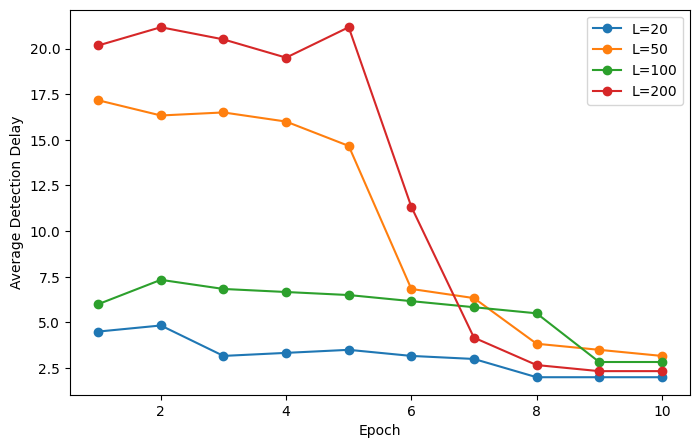

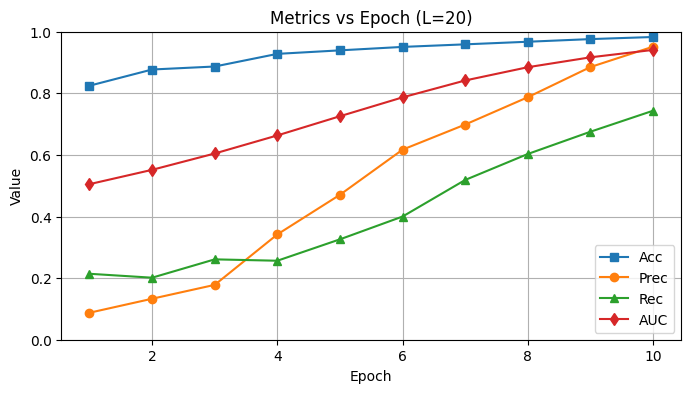

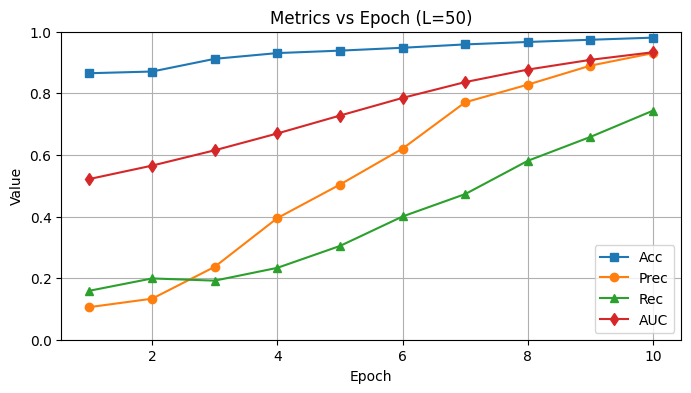

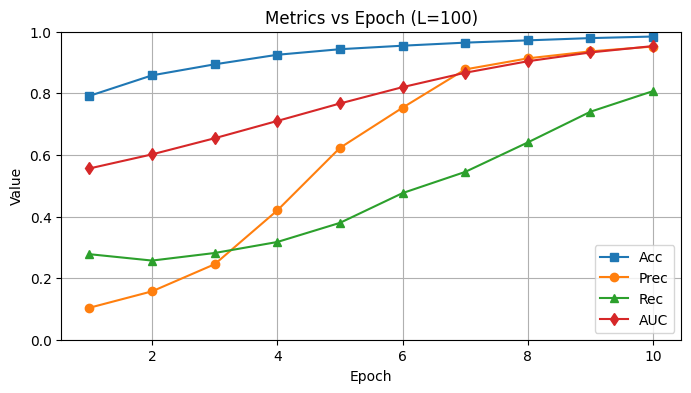

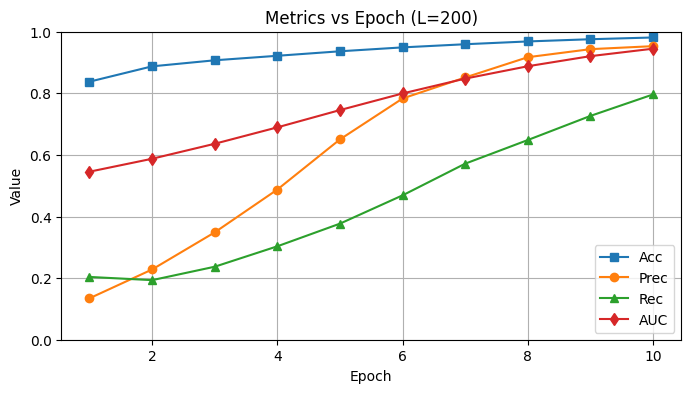

In [31]:
# ── D) HYPERPARAMS & DATA ──
num_epochs     =  10
window_lengths = [20, 50, 100, 200]
batch_size     = 64

val_indices = val_subset.indices
val_true_ts = np.array(test_labels[val_indices], dtype=int)


metrics_history = {
    L: {k: [] for k in
        ['accuracy','precision','recall','auc_roc','f1_pa','threshold','add']}
    for L in window_lengths
}

scheduler = ReduceLROnPlateau(optimizer, mode='max',
                              factor=0.5, patience=5, verbose=True)

# ── E) TRAIN/VALIDATE ──
for epoch in range(num_epochs):
    # TRAIN
    model.train()
    total_loss = 0.0
    for x1, x2, y, m1, m2 in train_loader:
        x1, x2, y, m1, m2 = [t.to(device) for t in (x1,x2,y,m1,m2)]
        optimizer.zero_grad()
        ll_g, ll_v = model(x1, x2, mask1=m1, mask2=m2)
        loss = contrastive_loss(ll_g, ll_v, y, alpha=0.3, base_margin=500.)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"\nEpoch {epoch+1}/{num_epochs} — Loss: {total_loss/len(train_loader):.4f}")

    # VALIDATE each L
    for L in window_lengths:
        # val_ds = WindowedDataset(test_features[val_indices],
        #                          test_labels[val_indices],
        #                          window_size=L, stride=1)

        k = 3
        val_ds = WindowedDataset(
            test_features[val_indices],
            test_labels[val_indices],
            window_size=L,
            stride=1,
            min_anoms=k
        )
        val_loader_L = DataLoader(val_ds,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=2)

        stats = validate(model, val_loader_L, device,
                         threshold=None,
                         window_size=L,
                         true_ts_labels=val_true_ts,
                         stride=1)
        for k in metrics_history[L]:
            metrics_history[L][k].append(stats[k])

        print(f" [L={L:3d}] Acc={stats['accuracy']:.3f}  "
              f"Prec={stats['precision']:.3f}  Rec={stats['recall']:.3f}  "
              f"AUC={stats['auc_roc']:.3f}  F1_PA={stats['f1_pa']:.3f}  "
              f"Thr={stats['threshold']:.3f}  ADD={stats['add']:.2f}")

    # scheduler.step(metrics_history[window_lengths[0]]['auc_roc'][-1])

# ── F) PLOTS ──

epochs = np.arange(1, num_epochs+1)
# ADD curves
plt.figure(figsize=(8,5))
for L in window_lengths:
    plt.plot(epochs, metrics_history[L]['add'], marker='o', label=f"L={L}")
plt.xlabel("Epoch"); plt.ylabel("Average Detection Delay"); plt.legend(); plt.show()

# Classification metrics per L
for L in window_lengths:
    plt.figure(figsize=(8,4))
    for m,label,mk in [
        ('accuracy', 'Acc','s'),
        ('precision','Prec','o'),
        ('recall','Rec','^'),
        ('auc_roc','AUC','d')
    ]:
        plt.plot(epochs, metrics_history[L][m],
                 marker=mk, label=label)
    plt.title(f"Metrics vs Epoch (L={L})")
    plt.xlabel("Epoch"); plt.ylabel("Value")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, loader, device, dataset_name="Dataset"):
    """
    This function visualizes the latent space by extracting embeddings from the model
    for each batch in 'loader'. We'll handle 3 batch-size scenarios:
      1) 5 items: (x1, x2, labels, x1_mask, x2_mask)
      2) 3 items: (x1, x2, labels)
      3) 2 items: (features, labels)
    We'll assume the model has a method 'get_embeddings(x1, x2, mask1, mask2)'
    that returns an embedding (e.g. shape (batch_size, embed_dim)).
    """

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch

    model.eval()

    all_embeddings = []
    all_labels     = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 5:
                # (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # We'll call some method get_embeddings() if your model has it
                embeddings = model.get_embeddings(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 3:
                # (padded_x1, padded_x2, batch_labels)
                padded_x1, padded_x2, batch_labels = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                embeddings = model.get_embeddings(padded_x1, padded_x2)

            elif len(batch) == 2:
                # (features, labels)
                features, batch_labels = batch

                features = features.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                # If model expects two inputs, pass features twice
                # or adapt if your model uses a single input in get_embeddings
                embeddings = model.get_embeddings(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Convert embeddings + labels to CPU
            emb_np = embeddings.cpu().numpy()
            lbl_np = batch_labels.cpu().numpy()

            all_embeddings.append(emb_np)
            all_labels.append(lbl_np)

    # Concat all
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # shape (total_samples, embed_dim)
    all_labels     = np.concatenate(all_labels,     axis=0)  # shape (total_samples,)

    # Suppose we do a 2D visualization via e.g. TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    emb_2d = tsne.fit_transform(all_embeddings)

    # Plot
    plt.figure(figsize=(8,6))
    # separate normal vs anomaly for coloring
    normal_mask  = (all_labels == 0)
    anomaly_mask = (all_labels == 1)

    plt.scatter(emb_2d[normal_mask,0],  emb_2d[normal_mask,1],  c='blue',  alpha=0.5, label='Normal')
    plt.scatter(emb_2d[anomaly_mask,0], emb_2d[anomaly_mask,1], c='red',   alpha=0.5, label='Anomaly')

    plt.title(f"Latent Space Visualization - {dataset_name}")
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


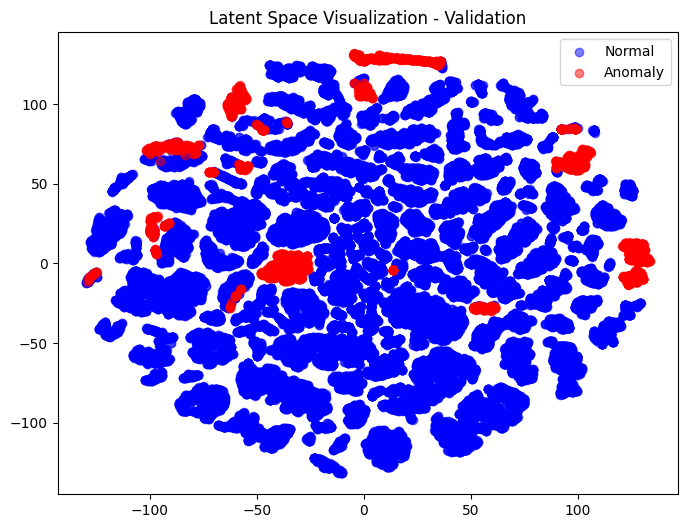

In [ ]:
# Visualize the latent space for the training set
#visualize_latent_space(model, train_loader, device, dataset_name="Train")

# Visualize the latent space for the test set
visualize_latent_space(model, val_loader, device, dataset_name="Validation")
